# Classification through a ROIAlign layer

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

## Import data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split

root_dir = '/Users/jcboyd/Data/torch'
output_dir = './'

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # channel-wise means/stds
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # channel-wise means/stds
])

train_set = torchvision.datasets.MNIST(root=root_dir, train=True,
                                       download=True, transform=train_transform)

nb_train = len(train_set.targets)
idx_train, idx_val = train_test_split(np.arange(nb_train), test_size=5000)

train_sub = Subset(train_set, idx_train)
test_sub = Subset(train_set, idx_val)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_sub, batch_size=batch_size,
                                           shuffle=True  , num_workers=2, drop_last=True)

val_loader = torch.utils.data.DataLoader(test_sub, batch_size=batch_size,
                                         shuffle=False, num_workers=2, drop_last=True)

test_set = torchvision.datasets.CIFAR100(root=root_dir, train=False,
                                        download=True, transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2, drop_last=True)

Files already downloaded and verified


In [3]:
classes = train_set.classes
nb_classes = len(classes)
print(classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

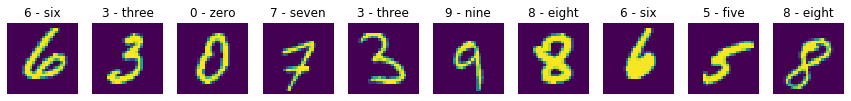

In [5]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig, axes = plt.subplots(figsize=(15, 3), ncols=10)

for i in range(10):
    img = 0.25 * images[i].permute(1, 2, 0) + 0.5
    axes[i].imshow(img.squeeze())
    axes[i].axis('off')
    axes[i].set_title(classes[labels[i]])

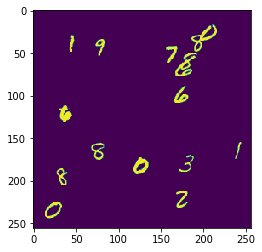

In [6]:
def get_canvas(images, dim=128):

    canvas = -np.ones((dim, dim))

    num_objs = images.shape[0]
    h, w = images.shape[2:]

    bboxes = []

    for i in range(num_objs):

        y, x = (np.random.randint(dim - h), np.random.randint(dim - w))

        bboxes.append([x, y, x + w, y + h])

        canvas[y:y+h, x:x+w] = np.maximum(canvas[y:y+h, x:x+w],
                                          images[i].numpy().squeeze())

    canvas = np.clip(canvas, -1, 1)

    return canvas, bboxes

images, _ = dataiter.next()
canvas, bboxes = get_canvas(images, dim=256)

plt.imshow(canvas)

## Construct model

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
import torch.nn as nn
from torchvision.ops import RoIAlign


class FCN(nn.Module):

    def __init__(self):

        super(FCN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

        self.roi_align = RoIAlign(output_size=(7, 7),
                                  spatial_scale=1, sampling_ratio=-1)

        self.fc = nn.Linear(784, 10)

    def forward(self, input_img, boxes):

        features = self.features(input_img)
        # N.B. box coordinates correspond to features, not input_img
        roi = self.roi_align(features, boxes)

        roi_flat = roi.view(-1, 784)
        logits = self.fc(roi_flat)

        return logits, features, roi

net = FCN().to(device)

/Users/jcboyd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


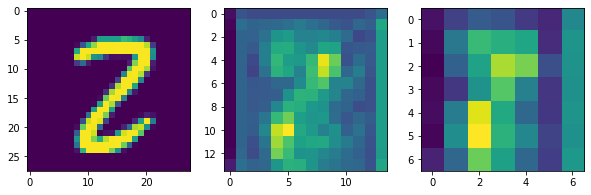

In [14]:
x_input = torch.tensor(images[0:1]).float()
boxes = torch.tensor([[0, 0, 0, 28, 28]]).float()
boxes = boxes / 2  # account for max pooling operation

output = net(x_input, boxes)

fig, axes = plt.subplots(figsize=(10, 3), ncols=3)

axes[0].imshow(x_input.squeeze())
axes[1].imshow(output[1].detach().numpy().squeeze()[1])
axes[2].imshow(output[2].detach().numpy().squeeze()[1])

In [10]:
canvas, bboxes = get_canvas(images)
print(bboxes)

[[32, 16, 60, 44], [37, 43, 65, 71], [0, 20, 28, 48], [11, 98, 39, 126], [16, 89, 44, 117], [46, 94, 74, 122], [18, 6, 46, 34], [93, 45, 121, 73], [61, 15, 89, 43], [80, 6, 108, 34], [20, 36, 48, 64], [1, 75, 29, 103], [84, 47, 112, 75], [98, 66, 126, 94], [51, 62, 79, 90], [88, 76, 116, 104]]


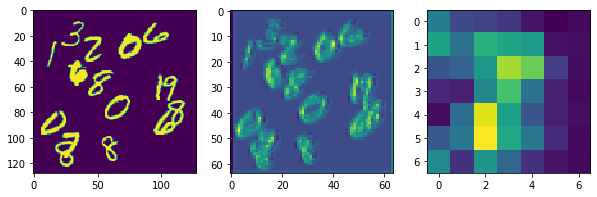

In [15]:
x_input = torch.tensor(canvas[None, None]).float()
boxes = torch.tensor([[0] + bboxes[0]]).float()
boxes = boxes / 2  # account for max pooling operation

output = net(x_input, boxes)

fig, axes = plt.subplots(figsize=(10, 3), ncols=3)

axes[0].imshow(x_input.squeeze())
axes[1].imshow(output[1].detach().numpy().squeeze()[1])
axes[2].imshow(output[2].detach().numpy().squeeze()[1])

## Model training

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)

val_data = iter(val_loader).next()
x_val, y_val = val_data[0].to(device), val_data[1].to(device)
val_acc_best = 0
val_accs = []

In [ ]:
def top_k_accuracy(outputs, y_val, k=1):

    """ Calculates top k accuracy for prediction

    Note top-k for k > 1 is only meaningful when modelling
    many similar classes.
    """

    top_k = torch.argsort(outputs, descending=True)[:, :k]
    in_top_k = torch.sum(top_k == y_val[:, None], axis=1)
    top_k_acc = torch.mean(in_top_k.double()).item()

    return top_k_acc

nb_epochs = 200

for epoch in range(nb_epochs):  # loop over the dataset multiple times

    running_loss = 0.0

    net = net.train()

    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        canvas, bboxes = get_canvas(inputs, dim=256)
        canvas = torch.tensor(canvas[None, None]).float().to(device)

        bboxes = torch.cat((torch.zeros(inputs.shape[0])[:, None],
                            torch.tensor(bboxes).float() / 2), axis=1)
        bboxes = bboxes.float().to(device)

        # zero gradients
        optimizer.zero_grad()

        # feed forward
        outputs = net(canvas, bboxes)
        # calculate loss
        loss = criterion(outputs[0], labels)
        # backpropagate
        loss.backward()
        # gradient descent
        optimizer.step()

        running_loss += loss.item() * batch_size / len(train_sub.indices)

    net = net.eval()

    with torch.no_grad():
        
        bboxes = np.zeros((images.shape[0], 5))
        bboxes[:, 0] = np.arange(images.shape[0])
        bboxes[:, 1:] = np.repeat(np.array([[0, 0, 28, 28]]),
                                  images.shape[0], axis=0) / 2
        bboxes = torch.tensor(bboxes).float().to(device)

        val_outputs = torch.cat([net(data.to(device), bboxes)[0] for data, _ in val_loader])
        val_targets = torch.cat([target for _, target in val_loader]).to(device)

        top_1_acc = top_k_accuracy(val_outputs, val_targets, k=1)
        top_3_acc = top_k_accuracy(val_outputs, val_targets, k=3)

        val_accs.append(top_1_acc)

        val_loss = criterion(val_outputs, val_targets).item()  # N.B. item() important

        print('[%04d] train_loss: %.4f val_loss: %.4f top_1_acc: %.4f top_3_acc: %.4f' % (
            epoch, running_loss, val_loss, top_1_acc, top_3_acc))

        if top_1_acc > val_acc_best:
            val_acc_best = top_1_acc
            torch.save(net.state_dict(), os.path.join(output_dir, './cnn.torch'))

/Users/jcboyd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


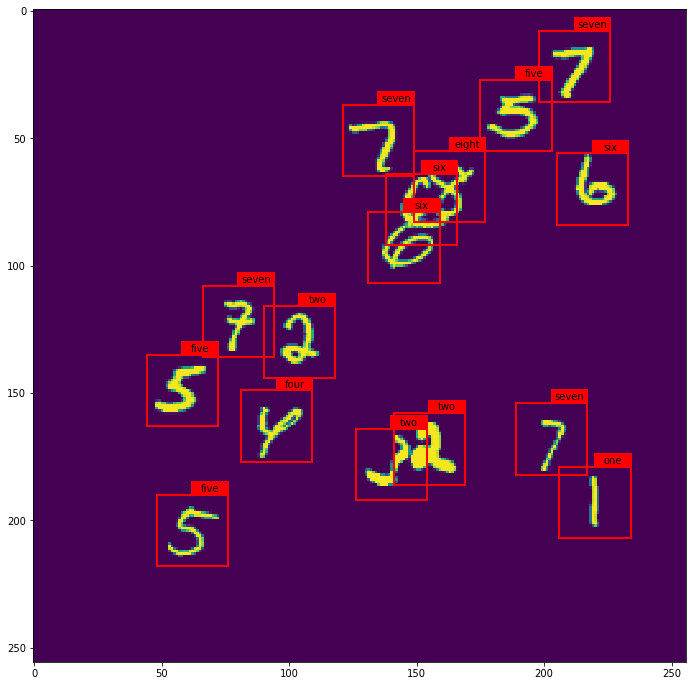

In [113]:
from torch import functional as F

canvas, bboxes = get_canvas(inputs, dim=256)

fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(canvas)

delta = 5

with torch.no_grad():

    for bbox in bboxes:

        pred = net(torch.tensor(canvas[None, None]).float().to(device),
                   torch.tensor([0] + bbox)[None,].float() / 2)
        pred_cls = torch.argmax(nn.functional.softmax(pred[0])).item()
        
        x_min, y_min, x_max, y_max = bbox

        colour = 'red'

        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                              linewidth=2, edgecolor=colour, facecolor='none')
        ax.add_patch(rect)
        rect = plt.Rectangle(((x_min + x_max) / 2, y_min - delta), (x_max - x_min) / 2, delta,
                      linewidth=2, edgecolor=colour, facecolor=colour)
        ax.add_patch(rect)

        ax.text(((x_min + x_max) / 2 + x_max) / 2, y_min - delta / 2, classes[pred_cls][4:],
                horizontalalignment='center', verticalalignment='center')#, transform=ax.transAxes)